# Upstream modes and antidots poison graphene quantum Hall effect

This notebook contains the codes that have been used to produce the simulations presented in the article "Upstream modes and antidots poison graphene quantum Hall effect" (https://arxiv.org/abs/2010.12499). 

In [1]:
import kwant
from kwant.digest import uniform    # a (deterministic) pseudorandom number generator
import numpy as np
import math
from math import atan2, pi, sqrt, cos, sin
from cmath import exp
import matplotlib
from matplotlib import pyplot as plt

from scipy.stats import rayleigh
from numpy import random as rd

from pylab import rcParams
# rcParams['figure.figsize'] = 5,5

### Fondamental constants

In [2]:
h = 6.626069e-34    # Planck constant (Js)
e = 1.602e-19       # electron charge (C)
c = 299792458       # Light celerity (m/s)
kB = 1.3806503e-23  # Boltzmann constant (kg m2/Ks2)
m_e = 9.1e-31       # electron mass (kg)
hbar = h/(2*pi)

### Main parameters

In [3]:
aG = 0.246e-9/sqrt(3)   # the inter-atomic spacing [nm]
tG = 2.7                # the hopping energy [eV]

W = 150e-9 ; L = 250e-9 # width and length of the electronic system
width_leads = 10e-9     # width of the leads
pos_leads = 110e-9      # pos of the leads along x

### Scaling

A scaling parameter $s$ is applied on the graphene lattice parameter $a_{latt}$ ($a_{lat}= \sqrt{3}a$) and on the 
hopping parameter $t$ in order to keep the Fermi velocity $v_F = 3a_{latt}t/2\hbar$ constant. Hence, the Fermi 
wavevector $k_F = E_F/\hbar v_F$ remains also constant for the same value of Fermi energy $E_F$.

In [4]:
scaling = 4           # scaling parameter 

a = aG * scaling      # scaled inter-atomic spacing
t = tG/scaling        # scaled hopping energy

In this simulation, the effect of the back gate, and the related increase of charge carriers density at the sample edges, is described with an onsite parameter defined with respects to the Fermi energy $E_F$, kept at zero. However, for mathematical reasons, Kwant does not support an energy parameter set to zero. The Fermi energy has therefore been put to a value $E_{CNP}$, negligible compared to the hopping parameter $t$.

In [5]:
E_CNP = t/20000 

The width of the simulated system is defined in terms of an integer number of unit cells (along the $y$ direction). Hence, we avoid the presence of single atoms terminations at the graphene edges.

In [6]:
width_lab = int(W/(3*a))          # number of unit cells along the system width (y axis)
width = width_lab * 3 * a         # width in [nm] defined from limy_leads_lab
cellH = 3 * a                     # height of a unit cell
delta = a/10                      # delta is used to avoid setting the system limit just on an atom

Wdown = -width/2 + cellH - delta
Wup = width/2 - delta

### Parameters associated to the potential landscape

In [7]:
factE = 0.6        # Ratio between the potential in the bulk and at the edges

R_antidot = 36e-9  # Radius of the Lorentzian function used to simulate the antidot
y_antidot = 30e-9  # Position of the antidot along y, taken from the center of the system
V_antidot = -0.05  # Maximum of the Lorentzian function used to simulate the antidot
Wc = 80e-9         # Width of the transition between the low and high charge carriers density regions along the edges
wc = 65e-9         # Width of the high charge carriers density region along the edges

V_tip = 0          # Tip potential (initialized to zero)
R_tip = 200e-9     # Radius of the tip Lorentzian function used to simulate the tip potential
y_tip = 50e-9      # position of the tip potential along the y axis

## Definition of the potential

### Edge potential

In [8]:
def accum(site, Ef, Vc):
    """
    The function accum is used to define the increase of charge carriers density at the edges.

    """
    x, y = site.pos

    posy = W/2 - y - wc      # Redifinition of the distance y for the polynom function used below
    acc = 2 * Vc / (Wc**3)   # First parameter of the polynom used below
    acc2 = -3 * Vc / (Wc**2) # Second parameter of the polynom used below
    
    if y > W/2 - wc:         # Region of the high charge carriers density along the edges
        return Vc + Ef 
    elif y > W/2 - Wc - wc:  # Region of transition between the high and low charge carriers density regions
        return acc * (posy)**3 + acc2 * (posy)**2 + Vc + Ef # Polynom function of the transition region
    else:                    # Region of the low charge carriers density along the edges
        return Ef

### Edge potential in the leads

In [9]:
def accum_leads(site, Ef, Vc):
    x, y = site.pos

    return accum(site, Ef, Vc) + E_CNP

### Antidot potential

In [10]:
def antidot(x, y, V_antidot, R_antidot, y_antidot):
    return V_antidot * 1/(1 + (x**2 + (y - y_antidot)**2)/R_antidot**2) # Lorentzian function of the antidot

### Tip potential

In [11]:
def tip(x, y, V_tip, R_tip, y_tip):
    return V_tip * 1/(1 + (x**2 + (y - y_tip)**2)/R_tip**2) # Lorentzian function of the tip

### Sum of the different contributions of the potential

In [12]:
def pot(site, Bfield, V_antidot, R_antidot, y_antidot, Ef, Vc, V_tip, R_tip, y_tip):
    x, y = site.pos
    fam = site.family
    
    pot_val = accum(site, Ef, Vc) + antidot(x, y, V_antidot, R_antidot, y_antidot) + tip(x, y, V_tip, R_tip, y_tip)
    
    return pot_val + E_CNP

## Building the system

### Geometry

In [13]:
def geom(pos):
    x, y = pos
    return -L/2 < x < L/2 and Wdown < y < Wup

### Function 'hopping' that allows to include the magnetic field in the system

In [14]:
def hopping(site_i, site_j, Bfield):
    """
    Definition of the hopping parameter by including the magnetic field (parameter phi)
    
    """
    
    xi, yi = site_i.pos
    xj, yj = site_j.pos

    return -t * exp(-1j * np.pi * Bfield / (h/e) * (xi - xj) * (yi + yj))

### Graphene lattice

The graphene lattice is built by using a rectangular unit cell with 4 atoms. This is equivalent of using the honeycomb lattice of the Kwant package. However, the rectangular symmetry is more convenient when building the leads of the system.

In [15]:
graphene = kwant.lattice.general([(sqrt(3)*a, 0), (0, 3*a)], [(a*sqrt(3)/2, 0), (0, a/2), (0, 3*a/2)\
                                                              , (a*sqrt(3)/2, 2*a)], norbs = 1)
A, B, C, D = graphene.sublattices

### System builder

In [16]:
nlead = 4 # number of leads

def sys_builder():
    sys = kwant.Builder()                   # construction of the system
    sys[graphene.shape(geom, (0,0))] = pot  # the function onsite is given on each node
    hoppings = (((0, 0), B, A), ((0, 0), C, B), ((0, 0), D, C), ((-1, 0), A, B), ((-1, 0), D, C),\
                ((0, 1), A, D))             # the function hopping is given on each edge
    sys[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] = hopping

    """
    Definition of the leads

    """
    
    lead_ext = pos_leads + width_leads/2
    lead_int = pos_leads - width_leads/2

    def lead_shape(pos):
        x, y = pos
        return Wdown < y < Wup

    def lead_shape_left(pos):
        x, y = pos
        return -lead_ext < x < -lead_int

    def lead_shape_right(pos):
        x, y = pos
        return lead_ext > x > lead_int

    sym0 = kwant.TranslationalSymmetry(graphene.vec((-1, 0)))
    lead0 = kwant.Builder(sym0)
    lead0[graphene.shape(lead_shape, (0, 0))] = accum_leads
    lead0[graphene.neighbors()] = hopping

    sym1 = kwant.TranslationalSymmetry(graphene.vec((1, 0)))
    lead1 = kwant.Builder(sym1)
    lead1[graphene.shape(lead_shape, (0, 0))] = accum_leads
    lead1[graphene.neighbors()] = hopping

    sym2 = kwant.TranslationalSymmetry(graphene.vec((0, 1)))
    lead2 = kwant.Builder(sym2)
    lead2[graphene.shape(lead_shape_left, (-pos_leads, 0))] = accum_leads
    lead2[graphene.neighbors()] = hopping

    sym3 = kwant.TranslationalSymmetry(graphene.vec((0, -1)))
    lead3 = kwant.Builder(sym3)
    lead3[graphene.shape(lead_shape_right, (pos_leads, 0))] = accum_leads
    lead3[graphene.neighbors()] = hopping

    lead4 = kwant.Builder(sym2)
    lead4[graphene.shape(lead_shape_right, (pos_leads, 0))] = accum_leads
    lead4[graphene.neighbors()] = hopping

    sys.attach_lead(lead0)
    sys.attach_lead(lead1)
    sys.attach_lead(lead2)
#     sys.attach_lead(lead3) # a fifth lead can be added to compute the Hall conductance Gxy
    sys.attach_lead(lead4)
 
    sys = sys.finalized()
    
    return sys

In [17]:
sys = sys_builder()

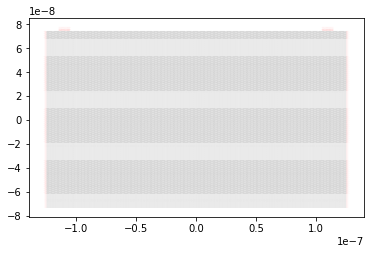

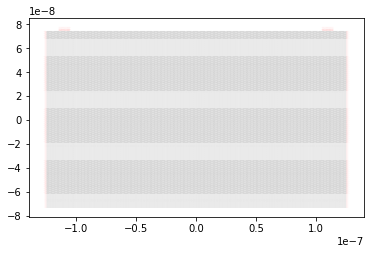

In [18]:
kwant.plot(sys, site_size = 1e-9)

## Landau levels and Fermi energy

In [19]:
Bfield = 12

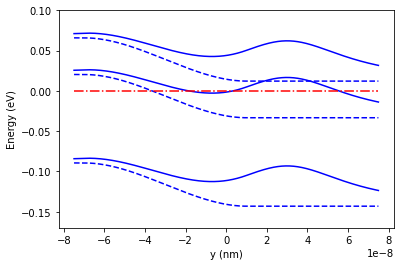

In [20]:
num_LL = 5

Efs = [0.0895] # np.linspace(0.085, 0.95, 5) # Values of the Fermi energy in the bulk

n = 1

def accum_graph(x, y, Ef, Vc):
    posy = W/2 - y - wc
    acc = 2 * Vc / (Wc**3)
    acc2 = -3 * Vc / (Wc**2)

    if y > W/2 - wc:
        return Vc + Ef
    elif posy < Wc:
        return acc * (posy)**3 + acc2 * (posy)**2 + Vc + Ef
    else:
        return Ef
    
def pot_graph(x, y, Ef, Vc, En, charge_bool):
    if charge_bool:
        pot_val = En - (antidot(0, y, V_antidot, R_antidot, y_antidot) + accum_graph(0, y, Ef, Vc))
    else:
        pot_val = En - accum_graph(0, y, Ef, Vc)
    
    return pot_val + E_CNP


for ind, Ef in enumerate(Efs):
    Vc = factE * Ef

    ys = np.linspace(-W/2, W/2, 1000)
    V = np.zeros(1000)
    V2 = np.zeros(1000)
    plt.figure()
    for n in range(3):
        En = 3/2 * a * t * sqrt(2 / hbar * e) * sqrt(n * Bfield) # Energy of the nth Landau level
        for i, y in enumerate(ys):
            V[i] = pot_graph(0, y, Ef, Vc, En, True)             # Potential with an antidot
            V2[i] = pot_graph(0, y, Ef, Vc, En, False)           # Potential without antidot

        plt.plot(ys, V, 'b')
        plt.plot(ys, V2, 'b--')
    plt.plot(ys, ys * 0, 'r-.')
    
    plt.ylim(ymin = -0.17, ymax = 0.1)

    plt.xlabel('y (nm)')
    plt.ylabel('Energy (eV)')
    
#     plt.savefig('En_B12.pdf')

    plt.show()


### Graphic of the potential 

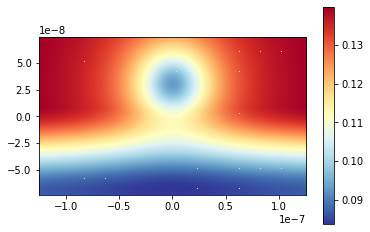

In [21]:
Ef = 0.0895
V_tip = 0
vals = [pot(sys.sites[n], Bfield=Bfield, V_antidot = V_antidot, R_antidot = R_antidot, y_antidot = y_antidot, Ef = Ef, \
                         Vc = Vc, V_tip = V_tip, R_tip = R_tip, y_tip = y_tip) for n in range(sys.graph.num_nodes)]
kwant.plotter.map(sys, vals, cmap = 'RdYlBu_r', method = 'cubic', file = 'pot.pdf', show = True, oversampling = 10)

## Computation of $R_{xx}$ as a function of $E_F$

In [22]:
Efs = np.linspace(0.086, 0.09, 400) # Range of Fermi energies
veclen = len(Efs)
xs = Efs

Rs = np.zeros([veclen,1])    # initalization of the Rxx array
Rxys = np.zeros([veclen,1])  # initalization of the Rxy array



for i, Ef in enumerate(Efs):
    try:
        dis_amp = 0.
        Vc = factE * Ef
        
        params=dict(Bfield=Bfield, V_antidot = V_antidot, R_antidot = R_antidot, y_antidot = y_antidot, Ef = Ef, \
                    Vc = Vc, V_tip = V_tip, R_tip = R_tip, y_tip = y_tip)
        
        """
        The code below is used to compute the Hall and the longitudinal resistivity. It is based on a solution proposed by
        Anton Akhmerov on the Kwant forum at the adress https://www.mail-archive.com/kwant-discuss@kwant-project.org/msg00110.html

        """
        
        s = kwant.smatrix(sys, energy = E_CNP, params = params)
        # First we calculate the conductance matrix given the scattering matrix S
        cond = np.array([[s.transmission(i, j) for j in range(nlead)] for i in range(nlead)])
        # Correct the reflection blocks, so that rows and columns sum to zero.
        cond -= np.diag(cond.sum(axis=0))
        # In order to calculate the nonlocal conductance we eliminate one row and one column 
        # from the condutcance matrix. This amounts to setting the corresponding voltage to zero 
        # and using current conservation to calculate the current through the last terminal.
        cm = s.conductance_matrix()[:-1, :-1]
        # We then set the current to be 1 in the lead 0, -1 in lead 2, and
        # calculate the voltage in lead 1 (so V_1 - V_3 since V_3 = 0).
        R = np.linalg.solve(cm, [1, -1, 0])[2]
        Rs[i] = R
#         Rxy = np.linalg.solve(cm, [1, -1, 0, 0])[3]
#         Rxys[i] = -Rxy
        
        print('iteration', i, 'succeded')
    except:
        print('problem encoutered at iteration', i)

iteration 0 succeded
iteration 1 succeded
iteration 2 succeded
iteration 3 succeded
iteration 4 succeded
iteration 5 succeded
iteration 6 succeded
iteration 7 succeded
iteration 8 succeded
iteration 9 succeded
iteration 10 succeded
iteration 11 succeded
iteration 12 succeded
iteration 13 succeded
iteration 14 succeded
iteration 15 succeded
iteration 16 succeded
iteration 17 succeded
iteration 18 succeded
iteration 19 succeded
iteration 20 succeded
iteration 21 succeded
iteration 22 succeded
iteration 23 succeded
iteration 24 succeded
iteration 25 succeded
iteration 26 succeded
iteration 27 succeded
iteration 28 succeded
iteration 29 succeded
iteration 30 succeded
iteration 31 succeded
iteration 32 succeded
iteration 33 succeded
iteration 34 succeded
iteration 35 succeded
iteration 36 succeded
iteration 37 succeded
iteration 38 succeded
iteration 39 succeded
iteration 40 succeded
iteration 41 succeded
iteration 42 succeded
iteration 43 succeded
iteration 44 succeded
iteration 45 succede

iteration 361 succeded
iteration 362 succeded
iteration 363 succeded
iteration 364 succeded
iteration 365 succeded
iteration 366 succeded
iteration 367 succeded
iteration 368 succeded
iteration 369 succeded
iteration 370 succeded
iteration 371 succeded
iteration 372 succeded
iteration 373 succeded
iteration 374 succeded
iteration 375 succeded
iteration 376 succeded
iteration 377 succeded
iteration 378 succeded
iteration 379 succeded
iteration 380 succeded
iteration 381 succeded
iteration 382 succeded
iteration 383 succeded
iteration 384 succeded
iteration 385 succeded
iteration 386 succeded
iteration 387 succeded
iteration 388 succeded
iteration 389 succeded
iteration 390 succeded
iteration 391 succeded
iteration 392 succeded
iteration 393 succeded
iteration 394 succeded
iteration 395 succeded
iteration 396 succeded
iteration 397 succeded
iteration 398 succeded
iteration 399 succeded


/home/moreaunic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


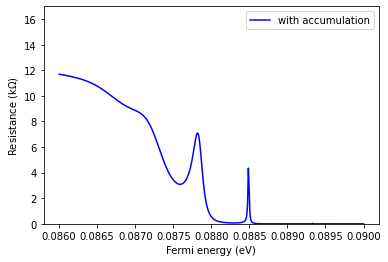

In [23]:
# %matplotlib notebook
plt.figure()
plt.plot(xs, Rs* (h / (2*e**2 * 1000)), 'b', label = 'with accumulation')
plt.plot(xs, np.divide(1, Rxys), 'k')

plt.xlabel('Fermi energy (eV)')
plt.ylabel('Resistance (k$\Omega$)')

plt.legend()
# plt.xlim(xmin = 0.08, xmax = 0.125)
plt.ylim(ymin = 0, ymax = 17)

# plt.savefig('B12T_s4_Ef_ycharge_18_Rcharge_12_Vcharge_005_nC.pdf')

plt.show()

## Computation of $R_{xx}$ as a function of $V_{tip}$

In [24]:
Vtips = np.linspace(0, -0.0045, 400)
veclen = len(Vtips)
xs = Vtips

Ef = 0.0895
V_tip = 0
R_tip = 200e-9
y_tip = 30e-9

Rs = np.zeros([veclen,1]) ; Rs2 = np.zeros([veclen,1])
Rxys = np.zeros([veclen,1]) ; Rxys2 = np.zeros([veclen,1])

for i, V_tip in enumerate(Vtips):
    try:
        dis_amp = 0.
        Vc = factE * Ef
        
        params=dict(Bfield=Bfield, V_antidot = V_antidot, R_antidot = R_antidot, y_antidot = y_antidot, Ef = Ef, \
                    Vc = Vc, V_tip = V_tip, R_tip = R_tip, y_tip = y_tip)
        
        """
        The code below is used to compute the Hall and the longitudinal resistivity. It is based on a solution proposed by
        Anton Akhmerov on the Kwant forum at the adress https://www.mail-archive.com/kwant-discuss@kwant-project.org/msg00110.html

        """
        
        s = kwant.smatrix(sys, energy = E_CNP, params = params)
        # First we calculate the conductance matrix given the scattering matrix S
        cond = np.array([[s.transmission(i, j) for j in range(nlead)] for i in range(nlead)])
        # Correct the reflection blocks, so that rows and columns sum to zero.
        cond -= np.diag(cond.sum(axis=0))
        # In order to calculate the nonlocal conductance we eliminate one row and one column 
        # from the condutcance matrix. This amounts to setting the corresponding voltage to zero 
        # and using current conservation to calculate the current through the last terminal.
        cm = s.conductance_matrix()[:-1, :-1]
        # We then set the current to be 1 in the lead 0, -1 in lead 2, and
        # calculate the voltage in lead 1 (so V_1 - V_3 since V_3 = 0).
        R = np.linalg.solve(cm, [1, -1, 0])[2]
        Rs[i] = R
#         Rxy = np.linalg.solve(cm, [1, -1, 0, 0])[3]
#         Rxys[i] = -Rxy
        
        print('iteration', i, 'succeded')
    except:
        print('problem encoutered at iteration', i)


iteration 0 succeded
iteration 1 succeded
iteration 2 succeded
iteration 3 succeded
iteration 4 succeded
iteration 5 succeded
iteration 6 succeded
iteration 7 succeded
iteration 8 succeded
iteration 9 succeded
iteration 10 succeded
iteration 11 succeded
iteration 12 succeded
iteration 13 succeded
iteration 14 succeded
iteration 15 succeded
iteration 16 succeded
iteration 17 succeded
iteration 18 succeded
iteration 19 succeded
iteration 20 succeded
iteration 21 succeded
iteration 22 succeded
iteration 23 succeded
iteration 24 succeded
iteration 25 succeded
iteration 26 succeded
iteration 27 succeded
iteration 28 succeded
iteration 29 succeded
iteration 30 succeded
iteration 31 succeded
iteration 32 succeded
iteration 33 succeded
iteration 34 succeded
iteration 35 succeded
iteration 36 succeded
iteration 37 succeded
iteration 38 succeded
iteration 39 succeded
iteration 40 succeded
iteration 41 succeded
iteration 42 succeded
iteration 43 succeded
iteration 44 succeded
iteration 45 succede

iteration 361 succeded
iteration 362 succeded
iteration 363 succeded
iteration 364 succeded
iteration 365 succeded
iteration 366 succeded
iteration 367 succeded
iteration 368 succeded
iteration 369 succeded
iteration 370 succeded
iteration 371 succeded
iteration 372 succeded
iteration 373 succeded
iteration 374 succeded
iteration 375 succeded
iteration 376 succeded
iteration 377 succeded
iteration 378 succeded
iteration 379 succeded
iteration 380 succeded
iteration 381 succeded
iteration 382 succeded
iteration 383 succeded
iteration 384 succeded
iteration 385 succeded
iteration 386 succeded
iteration 387 succeded
iteration 388 succeded
iteration 389 succeded
iteration 390 succeded
iteration 391 succeded
iteration 392 succeded
iteration 393 succeded
iteration 394 succeded
iteration 395 succeded
iteration 396 succeded
iteration 397 succeded
iteration 398 succeded
iteration 399 succeded


In [25]:
%matplotlib notebook
plt.figure()
# Vtips = np.linspace(0, -0.006, 400)

xs = Vtips
xgraph = xs

plt.plot(xgraph, Rs* (h / (2*e**2 * 1000)), 'b', label = 'with accumulation')
# plt.plot(xs, np.divide(1, Rxys), 'k')

plt.xlabel('Tip potential (eV)')
plt.ylabel('Resistance (k$\Omega$)')

plt.legend()

# plt.savefig('B12T_s4_Vtip__ycharge_30_Rcharge_36_Vcharge_005_nC.pdf')

plt.show()

<IPython.core.display.Javascript object>

## Computation of $R_{xx}$ as a function of $|\Delta n_{tip}|$

The relation between the carrier density $n(\vec{r}_i)$ and the onsite parameter $U(\vec{r}_i)$ is simply given by (https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.114.036601)
$$ n(\vec{r}_i) = \dfrac{1}{\pi}\left(\dfrac{U(\vec{r}_i)}{\hbar v_F}\right)^2 $$
By expressing the Fermi velocity in terms of $a$ and $t$ ($v_F = 3at/2\hbar$), $\Delta n_{tip}$ can easily be found by
$$ \Delta n_{tip} = \dfrac{4}{9\pi}\left(\dfrac{E_F + V_{max}}{at}\right)^2 - \dfrac{4}{9\pi}\left(\dfrac{E_F}{at}\right)^2 $$
where $E_F$ is the uniform onsite potential in the graphene bulk and $V_{max}$ is the maximum of the tip potential

In [26]:
# %matplotlib notebook
plt.figure()

xs = Vtips
xgraph = (np.square((xs+Ef)/(3*a*t/2))/np.pi - (Ef/(3*a*t/2))**2/np.pi)*(-1)

plt.plot(xgraph, Rs* (h / (2*e**2 * 1000)), 'b', label = 'with accumulation')
# plt.plot(xs, np.divide(1, Rxys), 'k')

plt.xlabel('$|\Delta n_{tip}|$ (m$^{-2}$)')
plt.ylabel('Resistance (k$\Omega$)')

plt.legend()

# plt.savefig('B12T_s4_Vtip__ycharge_30_Rcharge_36_Vcharge_005_nC_right.pdf')

plt.show()

<IPython.core.display.Javascript object>

## Computation of the local current density

In [27]:
Vtips = [-0.0012, -0.001638, -0.0018, -0.004]
Ef = 0.0895
R_tip = 200e-9
y_tip = 30e-9

import pylab as pyl

for i, V_tip in enumerate(Vtips):
    Vc = factE * Ef
    
    params=dict(Bfield=Bfield, V_antidot = V_antidot, R_antidot = R_antidot, y_antidot = y_antidot, Ef = Ef, \
                Vc = Vc, V_tip = V_tip, R_tip = R_tip, y_tip = y_tip)
    
    wfs = kwant.wave_function(sys, energy = E_CNP, params = params) # the wave function is obtained by giving the 
                                                                    # parameters in arguments
    scattering_wf = wfs(0)  # all scattering wave functions from lead 0
    
    current = kwant.operator.Current(sys)
    wave_int, box = kwant.plotter.interpolate_current(sys, sum(current(p, params = params) for p in scattering_wf))
    
    if i == 0:
        curr00 = wave_int[:, :, 0] # local current density along x
        curr01 = wave_int[:, :, 1] # local current density along y
        box0 = box
        
    if i == 1:
        curr10 = wave_int[:, :, 0] # local current density along x
        curr11 = wave_int[:, :, 1] # local current density along y
        box1 = box
        
    if i == 2:
        curr20 = wave_int[:, :, 0] # local current density along x
        curr21 = wave_int[:, :, 1] # local current density along y
        box2 = box
        
    if i == 3:
        curr30 = wave_int[:, :, 0] # local current density along x
        curr31 = wave_int[:, :, 1] # local current density along y
        box3 = box

In [28]:
from matplotlib.colors import LinearSegmentedColormap

cdict = {'red':   ((0.0, 0.0, 0.0),
                   (0.25, 0.0, 0.0), 
                   (0.5, 0.0, 0.0),
                   (0.75, 1.0, 1.0),
                   (1.0, 1.0, 1.0)),

         'green': ((0.0, 0.0, 0.0),
                   (0.25, 0.25, 0.25),
                   (0.5, 0.5, 0.5),
                   (0.75, 0.67, 0.67),
                   (1.0, 0.98, 0.98)),

         'blue':  ((0.0, 0.0, 0.0),
                   (0.25, 0.5, 0.5),
                   (0.5, 0.0, 0.0),
                   (0.75, 0.0, 0.0),
                   (1.0, 0.9, 0.9))}

rcy = LinearSegmentedColormap('home_made_colorbar', cdict)
plt.register_cmap(cmap=rcy)
cmap = plt.get_cmap('home_made_colorbar')

In [ ]:
import matplotlib.colors as col

Jmaxes = np.zeros(4)

"""
Determination of the maximum value of the local current density (Jmax) among the four maps computed above

"""

for i in range(4):
    
    if i == 0:
        J0 = np.sqrt(np.square(curr00) + np.square(curr01))
        Jmaxes[0] = np.amax(J0)
        
    if i == 1:
        J1 = np.sqrt(np.square(curr10) + np.square(curr11))
        Jmaxes[1] = np.amax(J1)
        
    if i == 2:
        J2 = np.sqrt(np.square(curr20) + np.square(curr21))
        Jmaxes[2] = np.amax(J2)

    if i == 3:
        J3 = np.sqrt(np.square(curr30) + np.square(curr31))
        Jmaxes[3] = np.amax(J3)

Jmax = np.amax(np.array(Jmaxes))

"""
Normalization of all the local current density maps by Jmax and plot of the obtained map

"""

for i in range(4):
    if i == 0:
        J = J0/Jmax
        box = box0
        Jx = curr00 ; Jy = curr01

    if i == 1:
        J = J1/Jmax
        box = box1
        Jx = curr10 ; Jy = curr11

    if i == 2:
        J = J2/Jmax
        box = box2
        Jx = curr20 ; Jy = curr21

    if i == 3:
        J = J3/Jmax
        box = box3
        Jx = curr30 ; Jy = curr31

    J = np.transpose(J)
    Jx = np.transpose(Jx)
    Jy = np.transpose(Jy)
    
    """
    Parameters for plotting the data
    
    """

    lw = 5*(np.sqrt(J))

    fig, ax = pyl.subplots()

    maxJx = np.amax(Jx)
    minJx = np.amin(Jx)

    deltac = 0.15
    color = Jx/np.amax(Jx) + deltac

    xmin = box[0][0]; xmax = box[0][1]; ymin = box[1][0]; ymax = box[1][1]
    x = np.linspace(xmin, xmax, len(J[0,:]))
    y = np.linspace(ymin, ymax, len(J[:,0]))
    X, Y = np.meshgrid(x, y)
    
    """
    Plot of the data
    
    """

    p = pyl.imshow(np.flip(np.log(J), 0), cmap='inferno', interpolation='gaussian', extent = (xmin, xmax, ymin, ymax), aspect='auto', vmax = 0, vmin = -7)
    # other interpolation : 'nearest'
    cb = fig.colorbar(p)
    cb.ax.set_title('J (a.u.)', fontsize = 12)
    # for the streamplot
    norm = col.Normalize(vmin=0., vmax=0.3, clip=False)
    plt.streamplot(X, Y, Jx, Jy, density=0.7, linewidth=lw, color=color, cmap='bwr', norm = norm)
    plt.xlabel('x (µm)', fontsize = 12)
    plt.ylabel('y (µm)', fontsize = 12)

    plt.axis('scaled')

    name = 'JDOS_log_' + str(i) + '.pdf'
#     plt.savefig(name, format='pdf')
    plt.show()

<IPython.core.display.Javascript object>

/home/moreaunic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:85: RuntimeWarning: divide by zero encountered in log


<IPython.core.display.Javascript object>